In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, date
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
from colorama import Fore

np.random.seed(4)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass

In [2]:
df = pd.read_csv("Aquifer_Petrignano.csv")
df

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
5218,26/06/2020,0.0,-25.68,-25.07,25.7,24.5,-29930.688,2.5
5219,27/06/2020,0.0,-25.80,-25.11,26.2,25.0,-31332.960,2.4
5220,28/06/2020,0.0,-25.80,-25.19,26.9,25.7,-32120.928,2.4
5221,29/06/2020,0.0,-25.78,-25.18,26.9,26.0,-30602.880,2.4


In [3]:
df.columns

Index(['Date', 'Rainfall_Bastia_Umbra', 'Depth_to_Groundwater_P24',
       'Depth_to_Groundwater_P25', 'Temperature_Bastia_Umbra',
       'Temperature_Petrignano', 'Volume_C10_Petrignano',
       'Hydrometry_Fiume_Chiascio_Petrignano'],
      dtype='object')

In [4]:
df = df[df.Rainfall_Bastia_Umbra.notna()]
df = df.reset_index(drop=True)
df.drop(columns=['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], inplace=True)

In [5]:
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']
targets = ['depth_to_groundwater']
features = ['date', 'rainfall', 'temperature', 'drainage_volume', 'river_hydrometry']

In [6]:
df['date']=pd.to_datetime(df['date'], dayfirst=True)
df.sort_values(by='date', inplace=True)

In [7]:
df

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
3,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
4,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3
...,...,...,...,...,...,...
4194,2020-06-26,0.0,-25.07,25.7,-29930.688,2.5
4195,2020-06-27,0.0,-25.11,26.2,-31332.960,2.4
4196,2020-06-28,0.0,-25.19,26.9,-32120.928,2.4
4197,2020-06-29,0.0,-25.18,26.9,-30602.880,2.4


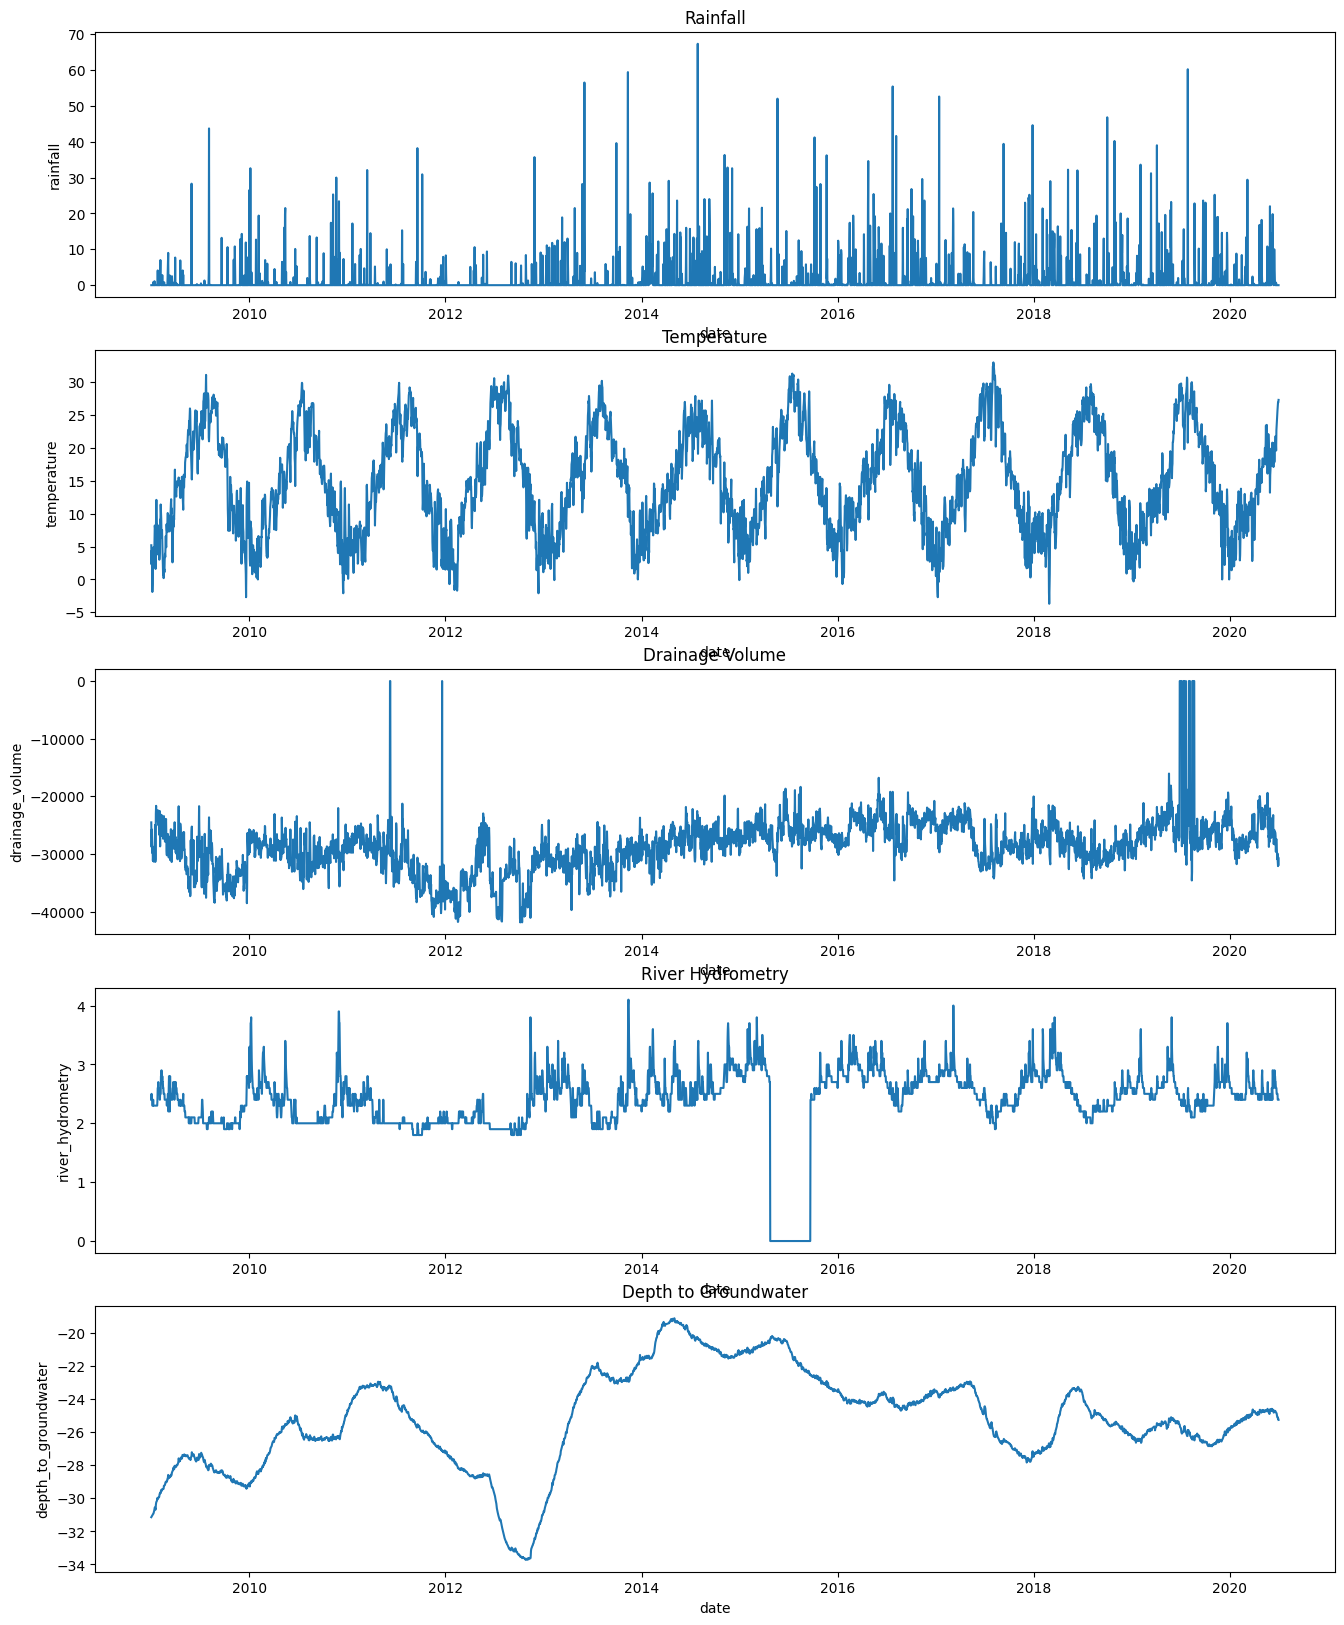

In [8]:
#plt.figure(figsize=(60,30))
fig1, axs1 = plt.subplots(nrows=5, ncols=1,figsize=(16, 20))

sns.lineplot(data=df, x='date', y='rainfall', ax=axs1[0])
axs1[0].set_title('Rainfall')
sns.lineplot(data=df, x='date', y='temperature', ax=axs1[1])
axs1[1].set_title('Temperature')
sns.lineplot(data=df, x='date', y='drainage_volume', ax=axs1[2])
axs1[2].set_title('Drainage Volume')
sns.lineplot(data=df, x='date', y='river_hydrometry', ax=axs1[3])
axs1[3].set_title('River Hydrometry')
sns.lineplot(data=df, x='date', y='depth_to_groundwater', ax=axs1[4])
axs1[4].set_title('Depth to Groundwater')
plt.show()


In [9]:
df['delta'] = df['date'] - df['date'].shift(1)
df['delta'].sum(), df['delta'].count()

(Timedelta('4198 days 00:00:00'), 4198)

In [10]:
df.drop(columns=['delta'], inplace=True)

Note that the tensor of this time series is a day

In [11]:
df.isna().sum()

,0
date,0
rainfall,0
depth_to_groundwater,27
temperature,0
drainage_volume,1
river_hydrometry,0


In [12]:
df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)

In [13]:
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

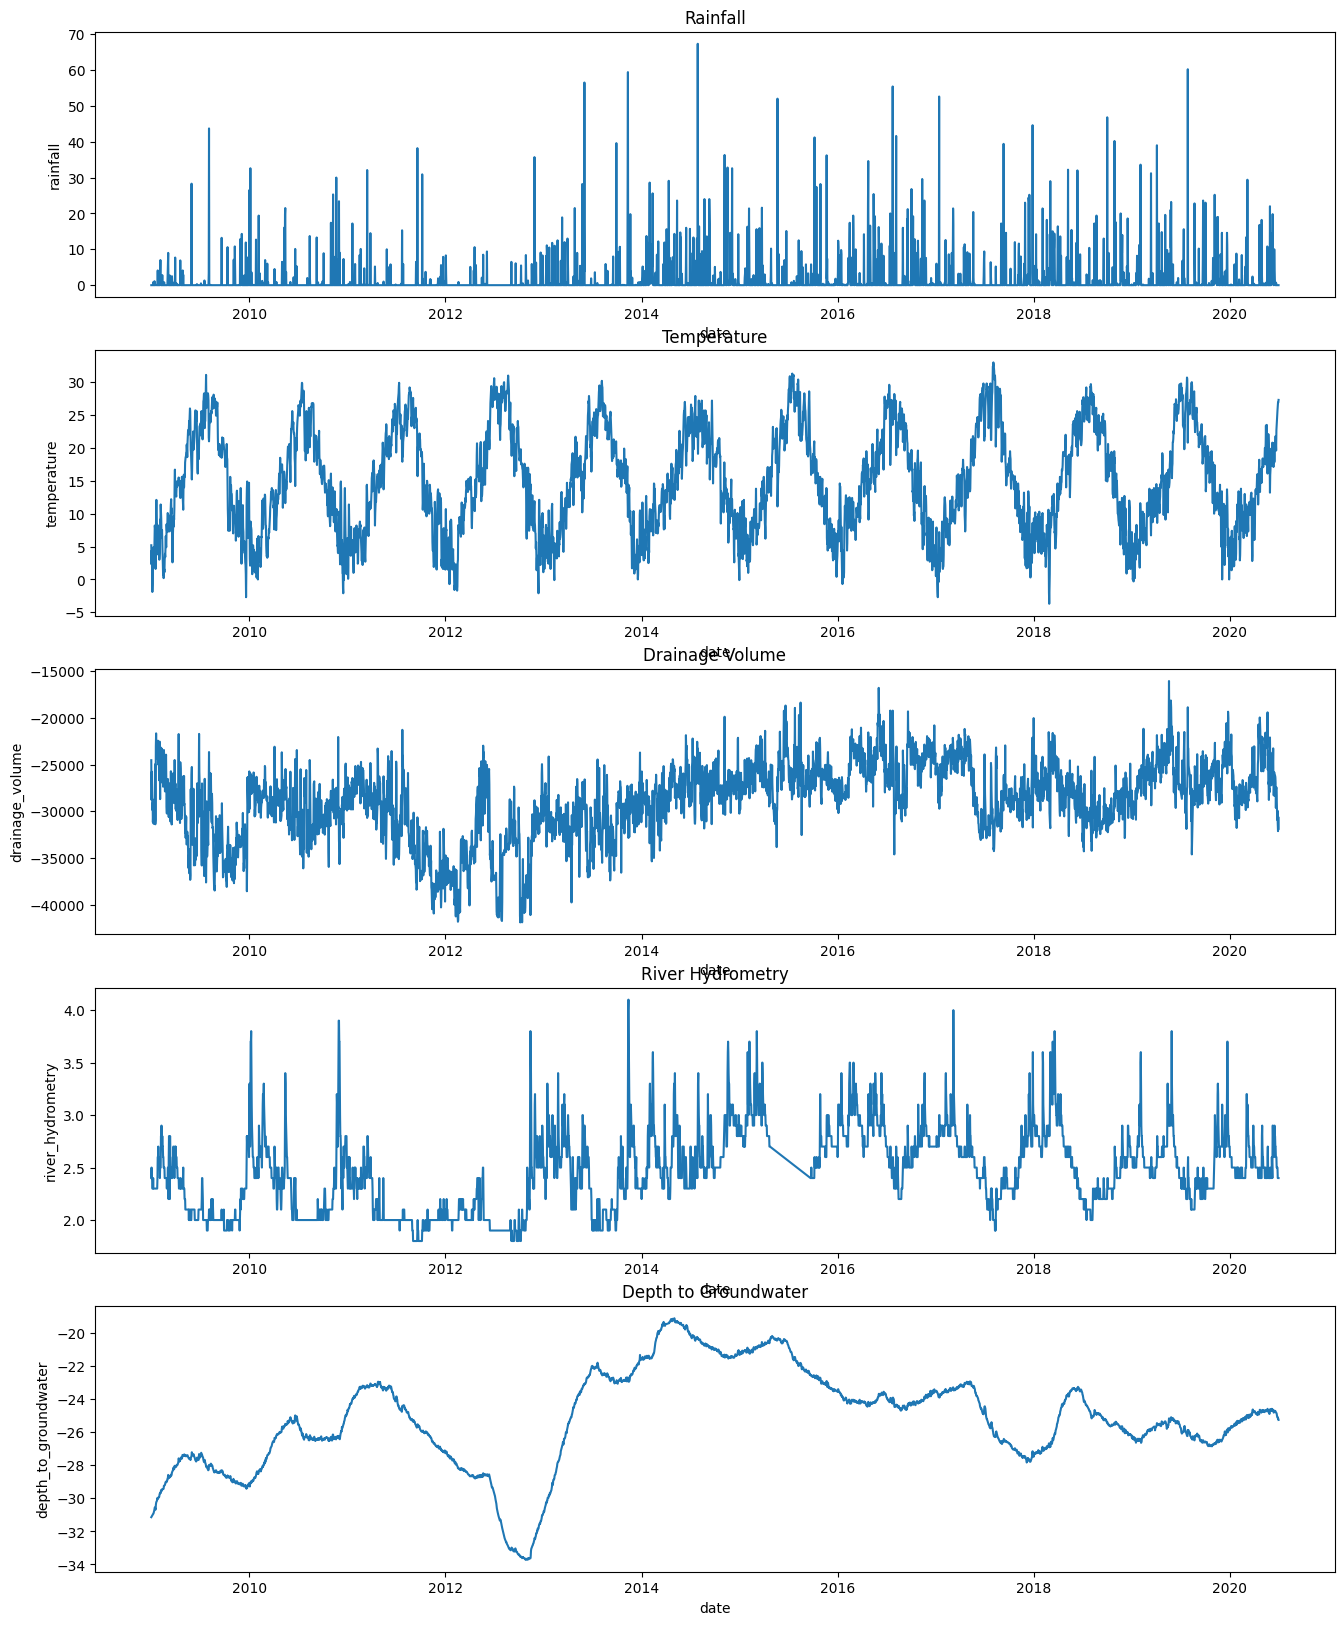

In [14]:
#plt.figure(figsize=(60,30))
fig1, axs1 = plt.subplots(nrows=5, ncols=1,figsize=(16, 20))

sns.lineplot(data=df, x='date', y='rainfall', ax=axs1[0])
axs1[0].set_title('Rainfall')
sns.lineplot(data=df, x='date', y='temperature', ax=axs1[1])
axs1[1].set_title('Temperature')
sns.lineplot(data=df, x='date', y='drainage_volume', ax=axs1[2])
axs1[2].set_title('Drainage Volume')
sns.lineplot(data=df, x='date', y='river_hydrometry', ax=axs1[3])
axs1[3].set_title('River Hydrometry')
sns.lineplot(data=df, x='date', y='depth_to_groundwater', ax=axs1[4])
axs1[4].set_title('Depth to Groundwater')
plt.show()

In [15]:
df.isna().sum()

,0
date,0
rainfall,0
depth_to_groundwater,0
temperature,0
drainage_volume,0
river_hydrometry,0


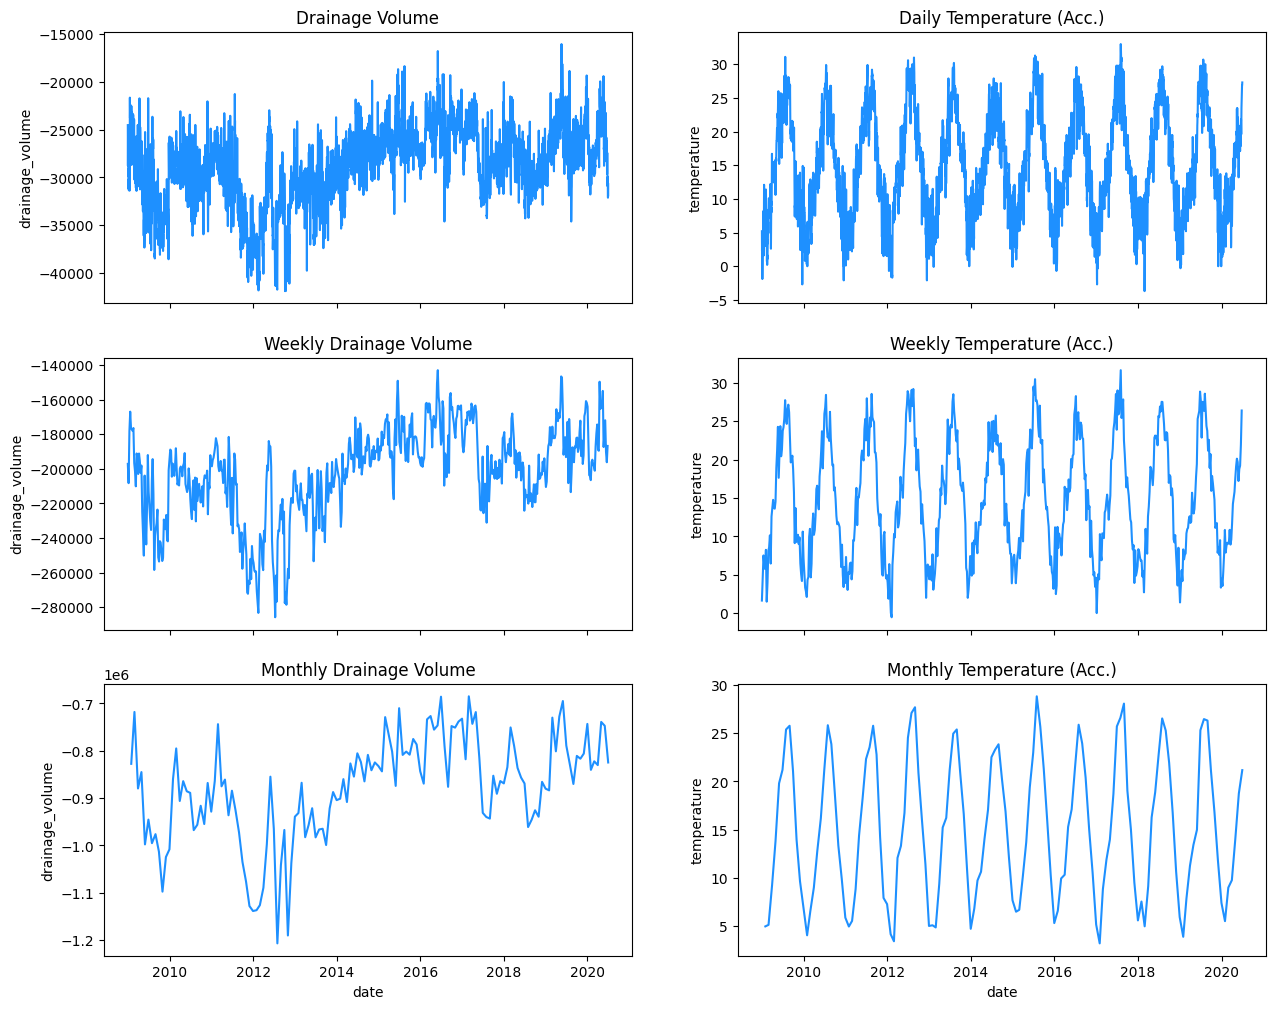

In [16]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(15,12))

sns.lineplot(x=df['date'], y=df['drainage_volume'], color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Drainage Volume')

rsamp_df = df[['date','drainage_volume']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(x=rsamp_df['date'],y= rsamp_df['drainage_volume'], color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('Weekly Drainage Volume')

rsamp_df = df[['date','drainage_volume']].resample('M', on='date').sum().reset_index(drop=False)
sns.lineplot(x=rsamp_df['date'], y=rsamp_df['drainage_volume'], color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Drainage Volume')

sns.lineplot(x=df['date'], y=df['temperature'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)')

rsamp_df = df[['date','temperature']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(x=rsamp_df['date'], y=rsamp_df['temperature'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)')

rsamp_df = df[['date','temperature']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(x=rsamp_df['date'], y=rsamp_df['temperature'], color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)')

plt.show()

Working with the weekly values seems to smooth the data

In [17]:
dsample = df[['date',
                 'depth_to_groundwater',
                 'temperature',
                 'drainage_volume',
                 'river_hydrometry',
                 'rainfall'
                ]].resample('7D', on='date').mean().reset_index(drop=False)
df_=dsample.copy()


In [18]:
for col in df_.columns:
  result = adfuller(df_[col].values,autolag = "AIC")
  print(f'p-value of {col}: {result[1]}')

p-value of date: 1.0
p-value of depth_to_groundwater: 0.047699190920208856
p-value of temperature: 2.825673334244129e-22
p-value of drainage_volume: 0.03398658265489102
p-value of river_hydrometry: 4.893936525215522e-05
p-value of rainfall: 0.011880998999360157


According the results of the Dickey-Fuller test we can say that all the columns are stationary.

In [19]:
df_['year'] = pd.DatetimeIndex(df_['date']).year
df_['month'] = pd.DatetimeIndex(df_['date']).month
df_['day'] = pd.DatetimeIndex(df_['date']).day
df_['day_of_year'] = pd.DatetimeIndex(df_['date']).dayofyear
df_['week_of_year'] = pd.PeriodIndex(df_['date']).week
df_['quarter'] = pd.DatetimeIndex(df_['date']).quarter
df_['season'] = df_['month'] % 12 // 3 + 1

df_[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head(100)

,date,year,month,day,day_of_year,week_of_year,quarter,season
0,2009-01-01,2009,1,1,1,1,1,1
1,2009-01-08,2009,1,8,8,2,1,1
2,2009-01-15,2009,1,15,15,3,1,1
3,2009-01-22,2009,1,22,22,4,1,1
4,2009-01-29,2009,1,29,29,5,1,1
...,...,...,...,...,...,...,...,...
95,2010-10-28,2010,10,28,301,43,4,4
96,2010-11-04,2010,11,4,308,44,4,4
97,2010-11-11,2010,11,11,315,45,4,4
98,2010-11-18,2010,11,18,322,46,4,4


In [20]:
month_in_year = 12
df_['month_sin'] = np.sin(2*np.pi*df_['month']/month_in_year)
df_['month_cos'] = np.cos(2*np.pi*df_['month']/month_in_year)

In [21]:
cols_study =  [
    'rainfall', 'temperature', 'drainage_volume',
    'river_hydrometry', 'depth_to_groundwater'
]

for column in cols_study:
    decomp = seasonal_decompose(df_[column], period=52, model='additive', extrapolate_trend='freq')
    df_[f"{column}_trend"] = decomp.trend
    df_[f"{column}_seasonal"] = decomp.seasonal

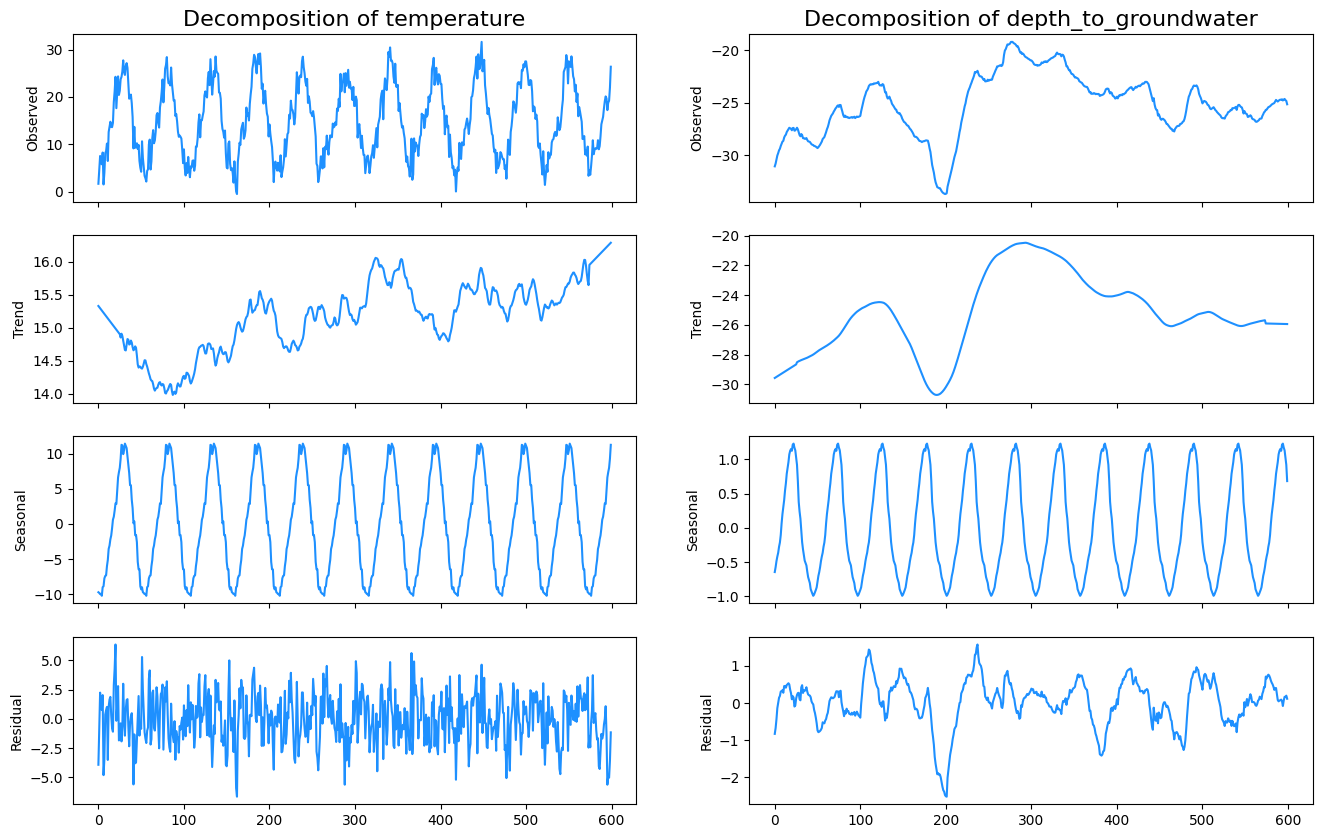

In [22]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,10))

for i, column in enumerate(['temperature', 'depth_to_groundwater']):

    res = seasonal_decompose(df_[column], period=52, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed')

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend')

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal')

    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual')

plt.show()

In [23]:
weeks_in_month = 4

for column in cols_study:
    df_[f'{column}_seasonal_shift_b_2m'] = df_[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df_[f'{column}_seasonal_shift_b_1m'] = df_[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df_[f'{column}_seasonal_shift_1m'] = df_[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df_[f'{column}_seasonal_shift_2m'] = df_[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df_[f'{column}_seasonal_shift_3m'] = df_[f'{column}_seasonal'].shift(3 * weeks_in_month)

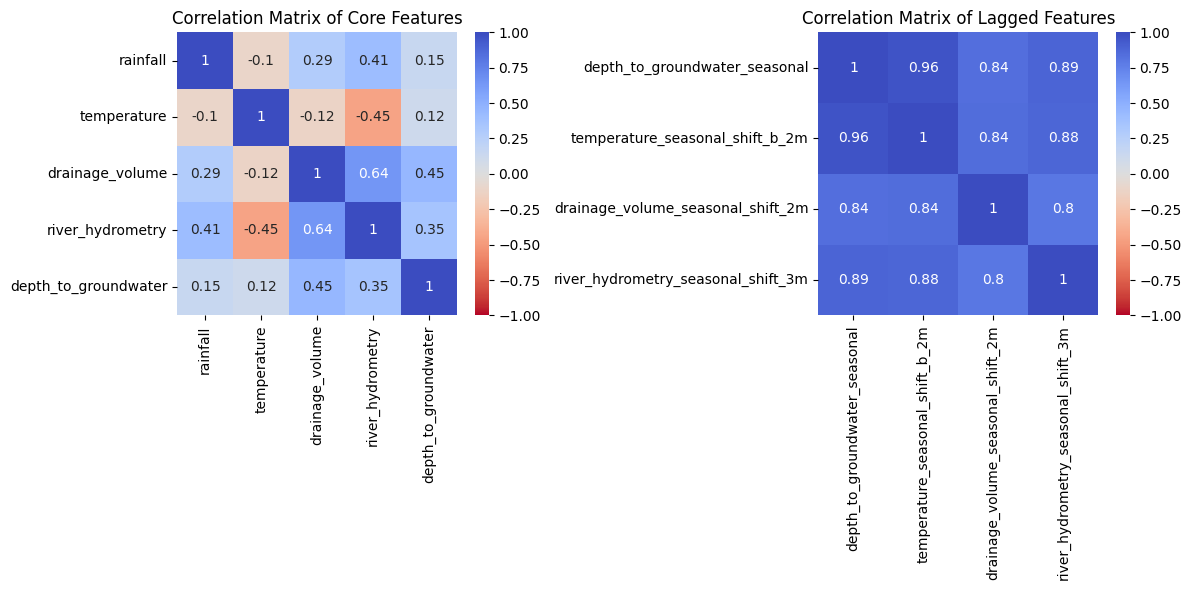

In [24]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

corrmat = df_[cols_study].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features')

shifted_cols = [
    'depth_to_groundwater_seasonal',
    'temperature_seasonal_shift_b_2m',
    'drainage_volume_seasonal_shift_2m',
    'river_hydrometry_seasonal_shift_3m'
]
corrmat = df_[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features')


plt.tight_layout()
plt.show()

The variables shifted 2 months have a higher correlation than the variables in the moment.

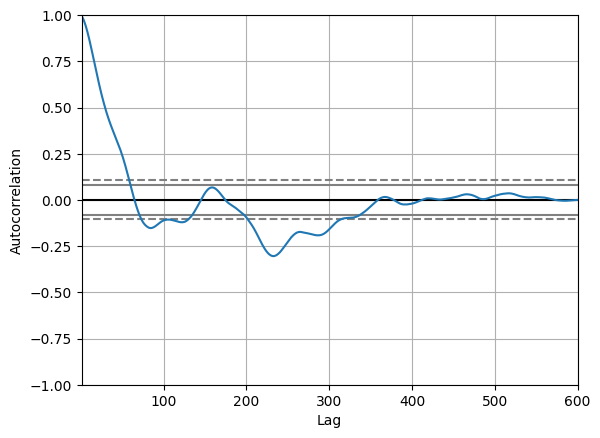

In [25]:
df_temp = df_.set_index('date').copy()
autocorrelation_plot(df_temp['depth_to_groundwater'])
plt.show()

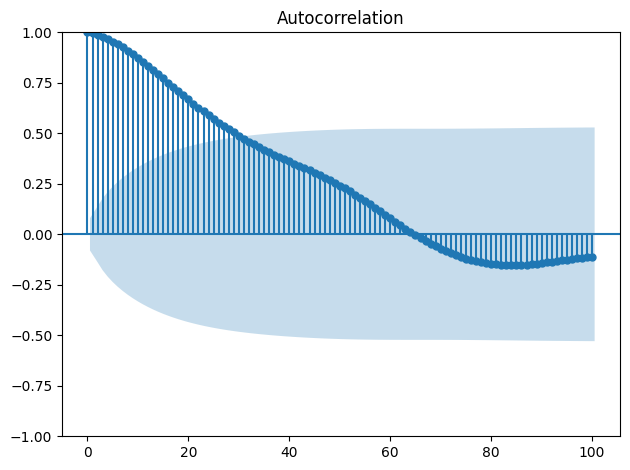

In [26]:
plot_acf(df_temp['depth_to_groundwater'], lags=100)

plt.tight_layout()

plt.show()

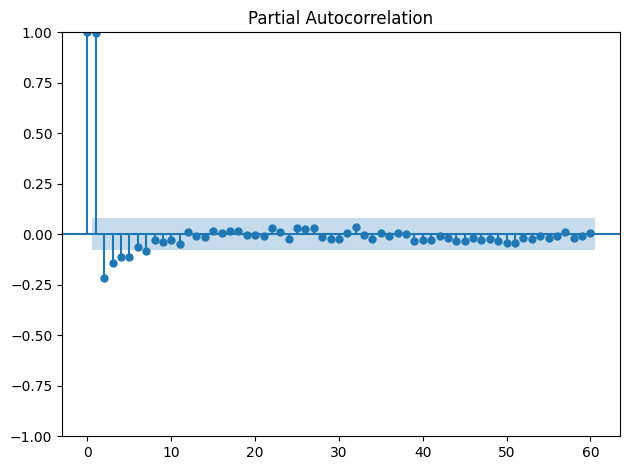

In [27]:
plot_pacf(df_temp['depth_to_groundwater'], lags=60)

plt.tight_layout()

plt.show()

The autocorrelation is strong at first but decreases over time

In [28]:
df_final=df_[['date',
            'depth_to_groundwater',
            'temperature_seasonal_shift_b_2m',
            'drainage_volume_seasonal_shift_2m',
            'river_hydrometry_seasonal_shift_3m']].set_index('date').copy()

In [29]:
df_final.shape

(600, 4)

In [30]:
train_size = int(df_final.shape[0]*0.80)
test_size = int(df_final.shape[0]*0.20)

In [31]:
df_train=df_final.iloc[:train_size,:]['depth_to_groundwater']
df_test=df_final.iloc[train_size:,:]['depth_to_groundwater']

In [32]:
from pmdarima import auto_arima

model = auto_arima(df_train, seasonal = True, trace = True, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-595.181, Time=5.55 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-246.296, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-539.555, Time=0.49 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-425.932, Time=2.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-247.074, Time=0.16 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-596.763, Time=5.28 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-598.657, Time=1.17 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-596.742, Time=2.97 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-599.530, Time=0.87 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=-597.732, Time=2.33 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-597.766, Time=4.79 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-596.098, Time=2.65 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=-468.708, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-601.474, Time=0.51 sec
 ARIMA(1,1,1)(1,0,0

In [33]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  480
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 304.604
Date:                Mon, 28 Oct 2024   AIC                           -603.207
Time:                        16:00:36   BIC                           -590.692
Sample:                    01-01-2009   HQIC                          -598.287
                         - 03-08-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9281      0.020     45.283      0.000       0.888       0.968
ma.L1         -0.5266      0.037    -14.420      0.000      -0.598      -0.455
sigma2         0.0164      0.001     24.708      0.0

In [34]:
forecast = model.predict(test_size)

In [35]:
pip install prophet

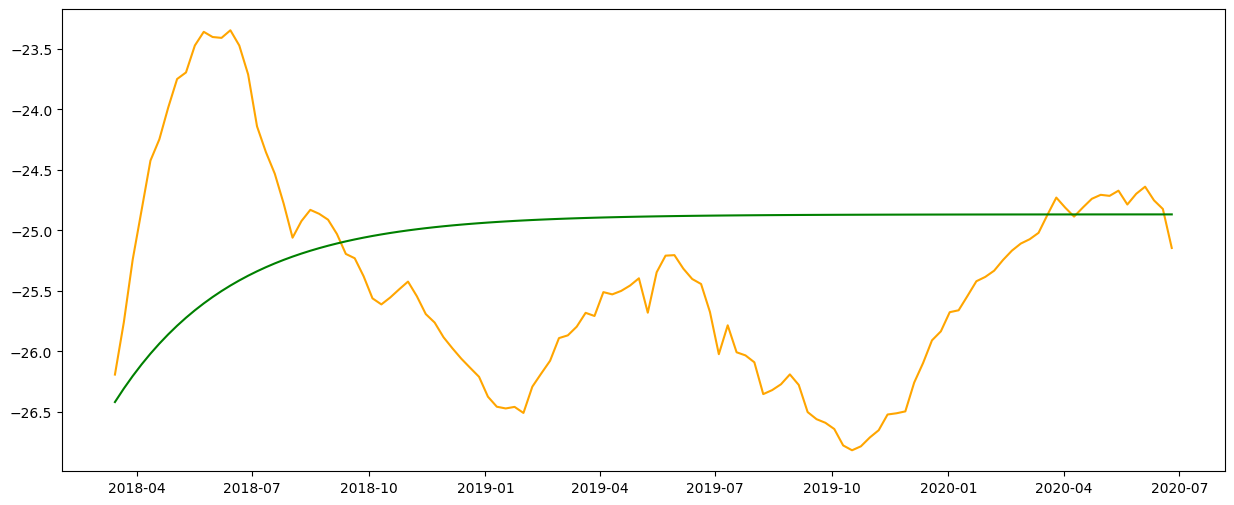

In [36]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

plt.plot(df_test,label='Test', color='orange')
plt.plot(forecast,label='Forecast', color='green')

plt.show()

In [37]:
data_for_prophet = df_[['date','depth_to_groundwater']].copy()
data_for_prophet.columns = ['ds','y']
df_train=data_for_prophet.iloc[:train_size,:]
df_test=data_for_prophet.iloc[train_size:,:]

In [38]:
from prophet import Prophet

m = Prophet()
m.fit(df_train)
future = m.make_future_dataframe(test_size)
predict = m.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp24ygqj_e/z9m1kkn2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp24ygqj_e/if_l6yfl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47206', 'data', 'file=/tmp/tmp24ygqj_e/z9m1kkn2.json', 'init=/tmp/tmp24ygqj_e/if_l6yfl.json', 'output', 'file=/tmp/tmp24ygqj_e/prophet_model5tjrc6mp/prophet_model-20241028160040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:00:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:00:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [39]:
predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-01-01,-29.457242,-30.702068,-29.222887,-29.457242,-29.457242,-0.528226,-0.528226,-0.528226,-0.528226,-0.528226,-0.528226,0.0,0.0,0.0,-29.985468
1,2009-01-08,-29.423957,-30.696618,-29.197607,-29.423957,-29.423957,-0.489641,-0.489641,-0.489641,-0.489641,-0.489641,-0.489641,0.0,0.0,0.0,-29.913598
2,2009-01-15,-29.390672,-30.605653,-29.070465,-29.390672,-29.390672,-0.440343,-0.440343,-0.440343,-0.440343,-0.440343,-0.440343,0.0,0.0,0.0,-29.831015
3,2009-01-22,-29.357387,-30.429952,-29.014373,-29.357387,-29.357387,-0.365391,-0.365391,-0.365391,-0.365391,-0.365391,-0.365391,0.0,0.0,0.0,-29.722778
4,2009-01-29,-29.324102,-30.330810,-28.897232,-29.324102,-29.324102,-0.269207,-0.269207,-0.269207,-0.269207,-0.269207,-0.269207,0.0,0.0,0.0,-29.593309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2018-07-02,-26.950244,-27.220243,-25.360161,-27.256831,-26.591658,0.656110,0.656110,0.656110,0.656110,0.656110,0.656110,0.0,0.0,0.0,-26.294134
596,2018-07-03,-26.954539,-27.164738,-25.384114,-27.266354,-26.592583,0.626819,0.626819,0.626819,0.626819,0.626819,0.626819,0.0,0.0,0.0,-26.327720
597,2018-07-04,-26.958835,-27.218240,-25.487463,-27.282166,-26.593507,0.597048,0.597048,0.597048,0.597048,0.597048,0.597048,0.0,0.0,0.0,-26.361787
598,2018-07-05,-26.963130,-27.212405,-25.431203,-27.292149,-26.594146,0.566925,0.566925,0.566925,0.566925,0.566925,0.566925,0.0,0.0,0.0,-26.396205


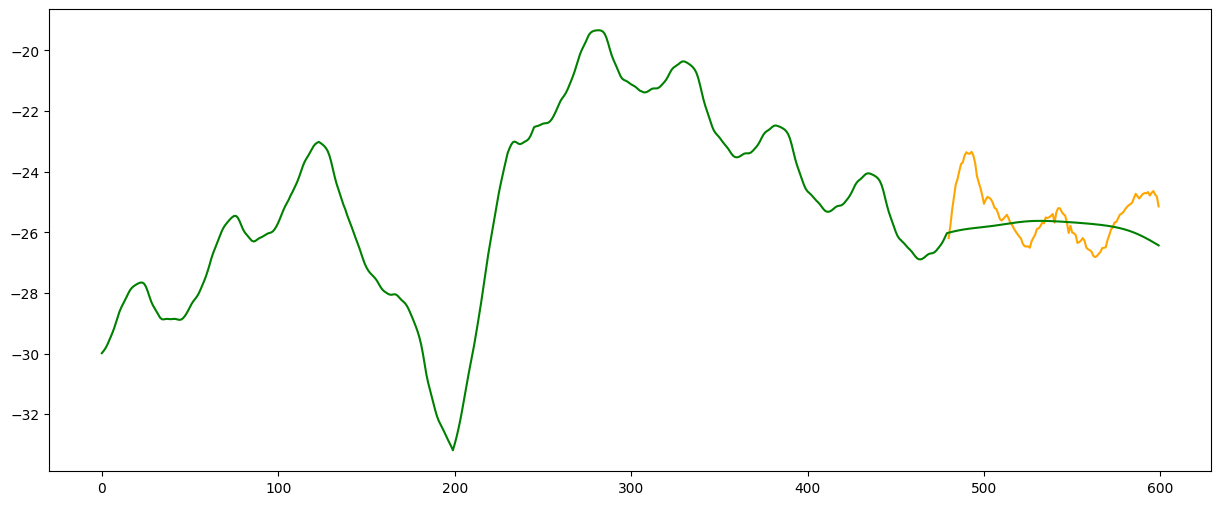

In [40]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

plt.plot(df_test['y'],label='Test', color='orange')
plt.plot(predict['yhat'],label='Forecast', color='green')

plt.show()

In [42]:
model = Prophet()
model.fit(df_train)
x_valid = model.make_future_dataframe(periods=test_size, freq='w')

y_pred = model.predict(x_valid)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp24ygqj_e/5d0g9xk8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp24ygqj_e/gxj4cfdf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63417', 'data', 'file=/tmp/tmp24ygqj_e/5d0g9xk8.json', 'init=/tmp/tmp24ygqj_e/gxj4cfdf.json', 'output', 'file=/tmp/tmp24ygqj_e/prophet_modelbn0kh2i4/prophet_model-20241028174545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


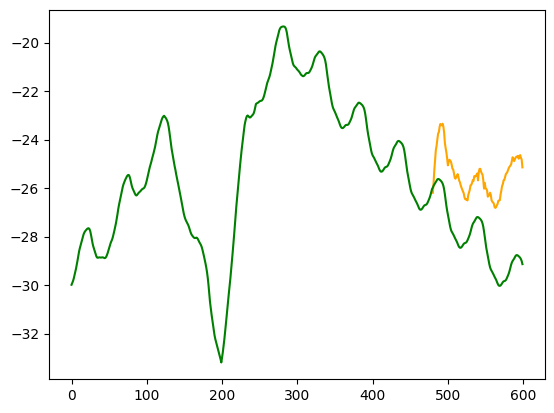

In [45]:
plt.plot(df_test['y'],label='Test', color='orange')
plt.plot(y_pred['yhat'],label='Forecast', color='green')

plt.show()

In [47]:
score_mse = mean_squared_error(df_test['y'], y_pred.tail(test_size)['yhat'])

In [48]:
print(f'The mean squared error is: {score_mse}')

The mean squared error is: 8.371518504224062
